# Winnipeg Service Request Project
### Author: Henrique Proba
In this project I'm using a dataset from the Winnipeg Open Data Portal which displays People's service requests. My goal here
is to analyze this data and display some interesting insights, plots and in the end show a map where each service request is located
on it.

ps: The Dataset can be found here: https://data.winnipeg.ca/Contact-Centre-311/311-Service-Request/4her-3th5


###  1 - Exploratory Data Analysis & Data Cleaning
####  1.1 - Importing the libraries that I'll be using.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gdp
from shapely.geometry import Point, Polygon

#### 1.2 - Reading the dataset and displaying the first 05 rows.

In [2]:
file_path = 'C:\Personal_Projects\my_projects\311_Service_Request.csv'
df = pd.read_csv(file_path)
df.head()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1
0,05/10/2017 02:22:00 PM,Street Maintenance,Sidewalk Repairs,Fort Rouge - East Fort Garry,South Portage,"(49.8870652997693, -97.1440154766177)"
1,08/25/2017 08:36:00 AM,By Law Enforcement,Neighbourhood Liveability Complaint,Transcona,Mission Gardens,"(49.8913473998213, -97.0379600434883)"
2,04/10/2017 11:11:00 AM,Sewer & Drainage,Sewer Backup,St. James,King Edward,"(49.8810695742732, -97.2097095425623)"
3,01/15/2018 11:44:00 AM,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8642636908888, -97.1003745057038)"
4,11/22/2018 10:06:00 AM,Garbage & Recycling,Missed Recycling Collection,St. Vital,Kingston Crescent,"(49.8535993554956, -97.1289960439088)"


#### 1.3 - Having a look at some information on the dataset using .describe() and .info()

In [3]:
# it may look a little different than the usual format(mean, std, min, max...), that's because there aren't numeric columns.
df.describe()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1
count,137613,137613,137613,137612,137612,137613
unique,123465,8,17,20,235,88044
top,02/27/2018 11:38:00 AM,Garbage & Recycling,Missed Garbage Collection,Mynarski,William Whyte,"(49.8523604856983, -97.1519348645188)"
freq,21,54719,30406,16402,5289,138


In [4]:
# This can be considered a 'clean'dataset since there are only two columns(Ward and Neighbourhood) with one missing value each.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137613 entries, 0 to 137612
Data columns (total 6 columns):
Date               137613 non-null object
Service Area       137613 non-null object
Service Request    137613 non-null object
Ward               137612 non-null object
Neighbourhood      137612 non-null object
Location 1         137613 non-null object
dtypes: object(6)
memory usage: 3.1+ MB


#### 1.4 - Filling missing data

In [ ]:
# Checking the null Values and it seems that it's in only one row. Based on its coordinates I see that the request happened in La Salle
df[df.isnull().any(axis=1)]

In [5]:
# In this case I'll basically fill the NaN with the string 'La Salle'
df.fillna('La Salle', inplace=True)

In [6]:
# Just to confirm the changes...
df.iloc[44091]

Date                              06/27/2017 11:32:00 AM
Service Area                     Parks and Urban Foresty
Service Request                                 Graffiti
Ward                                            La Salle
Neighbourhood                                   La Salle
Location 1         (49.7207652682073, -97.1753767016905)
Name: 44091, dtype: object

###  2 - Engineering 

#### 2.1 - Convert Date Column to datetime and generate two new columns from it: Dates and Hours

In [7]:
# Convert Date column into datetime and generation two list: dates and time
df['Date'] = pd.to_datetime(df['Date'])
dates = [d.date() for d in df['Date']]
time = [d.time() for d in df['Date']]

In [8]:
# Insert two new columns based on the two lists recently created.
df.insert(loc=1, column='Dates', value=dates)
df.insert(loc=2, column='Hours', value=time)

In [9]:
# Converting them into datetime as well
df['Dates'] = pd.to_datetime(df['Dates'])
df['Hours'] = pd.to_datetime(df['Hours'], format='%H:%M:%S').dt.hour

# I guess I won't be needing this column anymore
del df['Date']

#### 2.2 - Create two new extra columns(Season and Time) using Dates and Hours

In [11]:
def date_to_season(x):
    if x == 1:
        return 'Winter'
    if x == 2:
        return 'Spring'
    if x == 3:
        return 'Summer'
    if x == 4:
        return 'Autumn'
    
def hours_to_time(x):
    if x >= 6 and x <= 12:
        return 'Morning'
    if x > 12 and x <= 17:
        return 'Afternoon'
    if x > 17 and x <= 20:
        return 'Evening'
    if (x > 20) | (x < 6):
        return 'Night'
    
df['Season'] = df['Dates'].apply(lambda dt: (dt.month%12 + 3)//3)
df['Season'] = df['Season'].apply(date_to_season)
df['Time'] = df['Hours'].apply(hours_to_time)

In [12]:
#Checking the results of all the engineering that was applied so far
df.head()

,Dates,Hours,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Time
0,2017-05-10,14,Street Maintenance,Sidewalk Repairs,Fort Rouge - East Fort Garry,South Portage,"(49.8870652997693, -97.1440154766177)",Spring,Afternoon
1,2017-08-25,8,By Law Enforcement,Neighbourhood Liveability Complaint,Transcona,Mission Gardens,"(49.8913473998213, -97.0379600434883)",Summer,Morning
2,2017-04-10,11,Sewer & Drainage,Sewer Backup,St. James,King Edward,"(49.8810695742732, -97.2097095425623)",Spring,Morning
3,2018-01-15,11,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8642636908888, -97.1003745057038)",Winter,Morning
4,2018-11-22,10,Garbage & Recycling,Missed Recycling Collection,St. Vital,Kingston Crescent,"(49.8535993554956, -97.1289960439088)",Autumn,Morning


### 3 - Visualization and Insights

#### 3.1 Which Year had the highest service requests number ?

In [13]:
df['Dates'].groupby(df['Dates'].dt.year).agg('count')

Dates
2017    71145
2018    51170
2019    15298
Name: Dates, dtype: int64

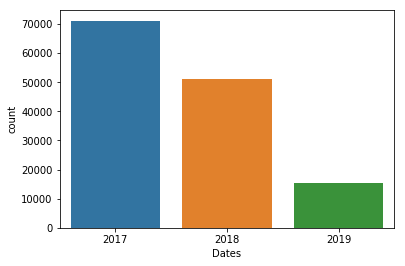

In [14]:
sns.countplot(df['Dates'].dt.year)

-  Unfortunately, the dataset is only covering 03 years of data but it seems (if the trend continues) that 2019 will have less service requests than 2018

#### 3.2 - Which Months usually have the highest service requests number ? 

In [15]:
# Let's first check in Detail each month of every year
df['Dates'].groupby([df['Dates'].dt.year,df['Dates'].dt.month]).count()

Dates  Dates
2017   1        10699
       2         4642
       3         6039
       4         4599
       5         5733
       6         7451
       7         5902
       8         5872
       9         4527
       10        9063
       11        3701
       12        2917
2018   1         3290
       2         2550
       3         7673
       4         4292
       5         5012
       6         5440
       7         5331
       8         4743
       9         3575
       10        3466
       11        3116
       12        2682
2019   1         4155
       2         5039
       3         5161
       4          943
Name: Dates, dtype: int64

In [16]:
# Now let's create a dataframe that won't count the year of 2019 and then group the months.
df_no_19 = df[(df['Dates'].dt.year == 2018) | (df['Dates'].dt.year == 2017)]
df_no_19.groupby(df_no_19['Dates'].dt.month)['Service Request'].size()

Dates
1     13989
2      7192
3     13712
4      8891
5     10745
6     12891
7     11233
8     10615
9      8102
10    12529
11     6817
12     5599
Name: Service Request, dtype: int64

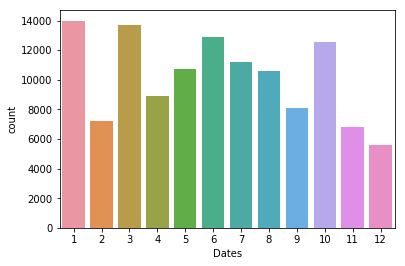

In [17]:
sns.countplot(df_no_19['Dates'].dt.month)

-  Months of January, March, June and October have a peak of service requests.

#### 3.3 - Which Time of the day has more service requests.

In [18]:
df_no_19.groupby('Time')['Service Request'].size()

Time
Afternoon    38688
Evening      21935
Morning      50344
Night        11348
Name: Service Request, dtype: int64

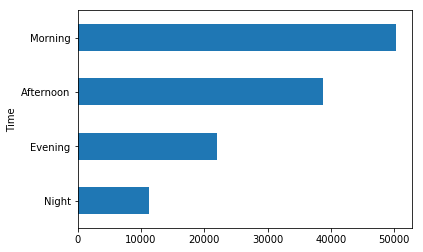

In [19]:
df_no_19.groupby('Time')['Service Request'].size().sort_values(ascending=True).plot(kind='barh')

-  Mornings are when service request are higher

#### 3.4 - Which Season has more service requests.

In [20]:
# Looks like Summer is the service request champion.
df_no_19.groupby('Season')['Service Request'].size()

Season
Autumn    27448
Spring    33348
Summer    34739
Winter    26780
Name: Service Request, dtype: int64

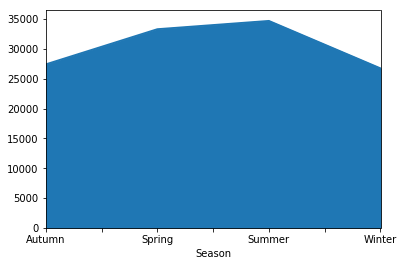

In [21]:
df_no_19.groupby('Season')['Service Request'].size().plot(kind='area')

-  Summer is the season with the highest number of service requests.

#### 3.4 - Types of Service Areas and Services Requests

In [22]:
df_no_19.groupby(['Service Area', 'Service Request']).size().sort_values(ascending=False)

Service Area             Service Request                    
Garbage & Recycling      Missed Garbage Collection              28484
By Law Enforcement       Neighbourhood Liveability Complaint    23093
Garbage & Recycling      Missed Recycling Collection            22935
Street Maintenance       Potholes                               13267
                         Snow Removal - Roads                    7056
                         Graffiti                                5180
Water                    Water Main Leak                         5125
Street Maintenance       Frozen Catch Basin                      3143
                         Sidewalk Repairs                        2841
Animal Services          Dog Complaint                           2614
Sewer & Drainage         Sewer Backup                            2356
Street Maintenance       Sanding                                 2279
                         Snow Removal - Sidewalks                1805
                         Litt

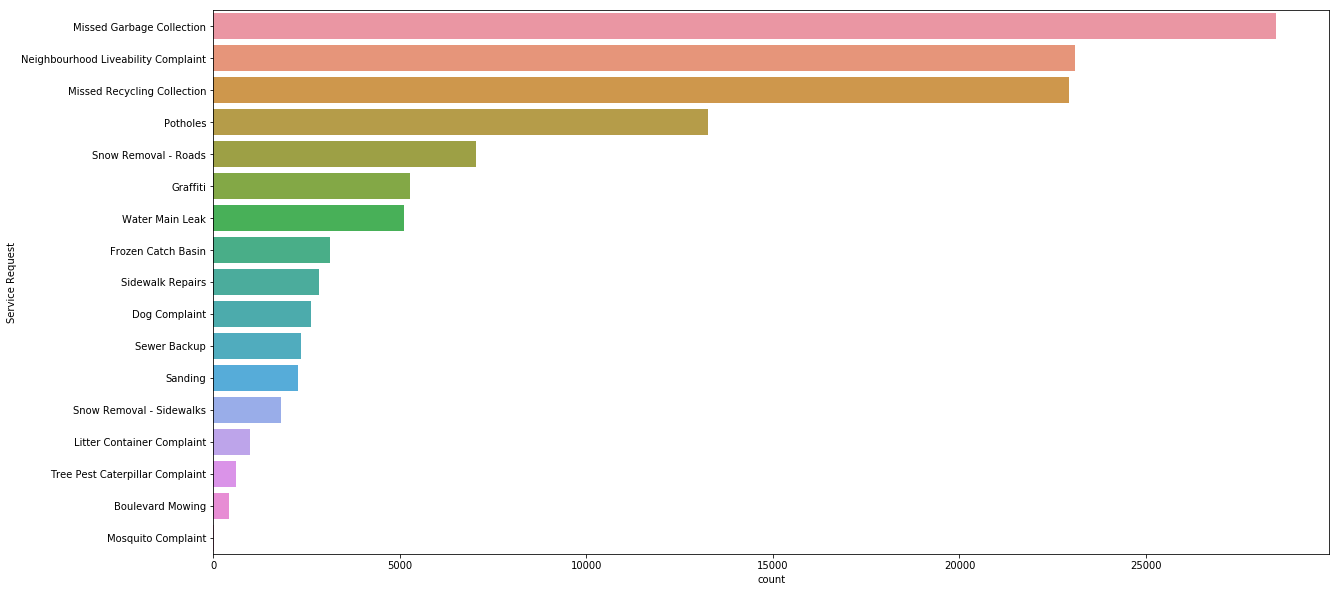

In [23]:
plt.subplots(figsize=(20,10))
sns.countplot(y=df_no_19['Service Request'], order=df_no_19['Service Request'].value_counts().index)
plt.show()

-  Each Service Area has one or many service requests. Looks like Missed Garbage Collection has the top position and Mosquito complaints (surprisingly!) has the least amount of service requests.

#### 3.4 Neighbourhoods and Service Requests

In [24]:
df_no_19.groupby('Neighbourhood')['Service Request'].size().sort_values(ascending = False).head(10)

Neighbourhood
William Whyte       4165
St. John's          3250
Rossmere-A          2401
Fort Richmond       2243
Daniel Mcintyre     2209
Chalmers            2084
River Park South    1944
Windsor Park        1844
Wolseley            1727
Minto               1672
Name: Service Request, dtype: int64

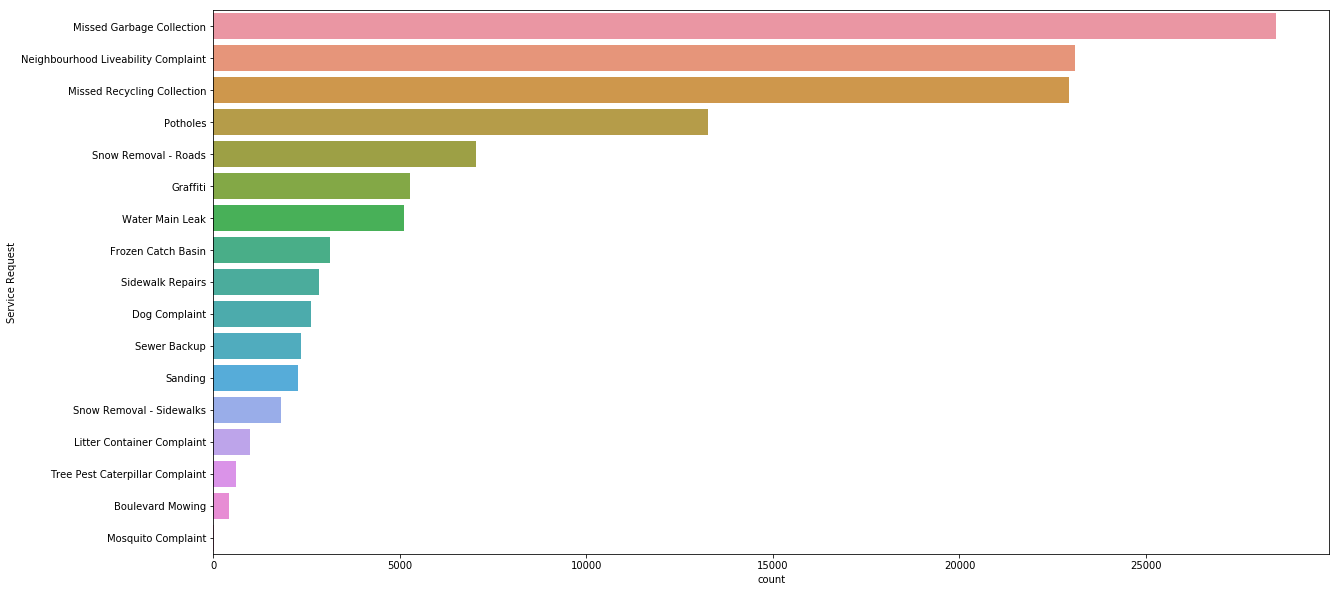

In [26]:
plt.subplots(figsize=(20,10))
sns.countplot(y=df_no_19['Service Request'], order=df_no_19['Service Request'].value_counts().index[0:17])
plt.show()

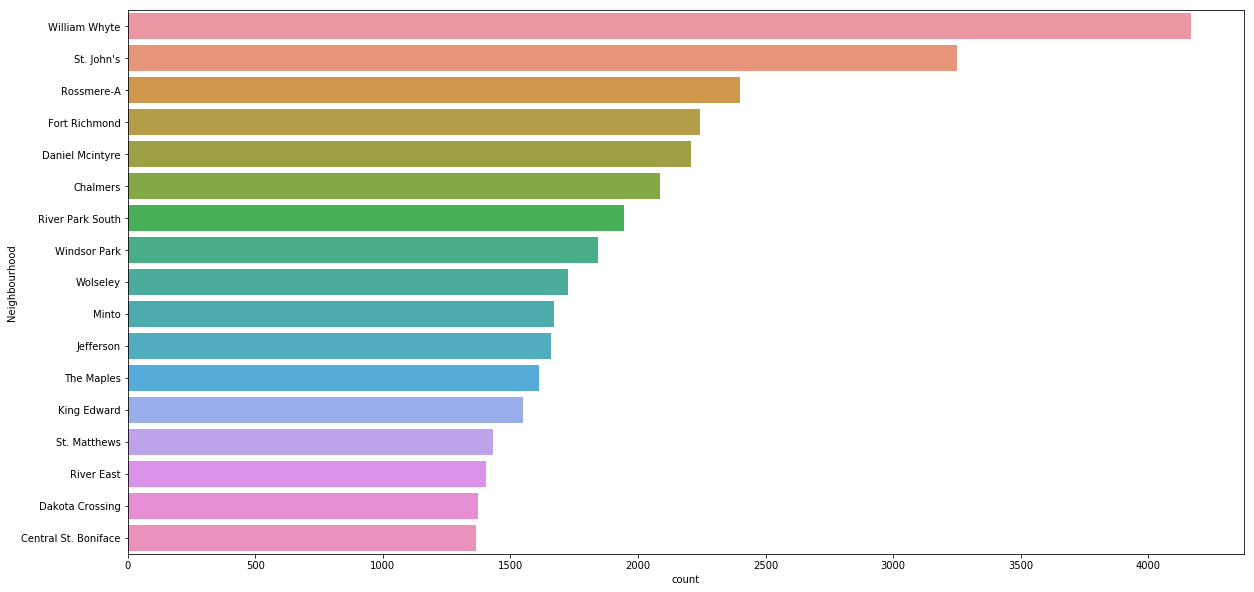

In [27]:
plt.subplots(figsize=(20,10))
sns.countplot(y=df_no_19['Neighbourhood'], order=df_no_19['Neighbourhood'].value_counts().index[0:17])
plt.show()

-  From the Neighbourhoods on the top 5 places, 04 are located north of downtown and 01 south of the city.
-  The major service requests on those areas are: Neighbourhood Liveability Complaint and Missed Garbage/Recycling Collection 

### 4- Display the Service Requests' location on a Winnipeg City Map.

#### 4.1 - Split the 'Location 1' column into Latitude and Longitude

In [28]:
street_map = gdp.read_file(r'C:\Personal_Projects\my_projects\geo_export_75ee7088-a365-4b6c-bb1a-1c21fc52a19a.shp')

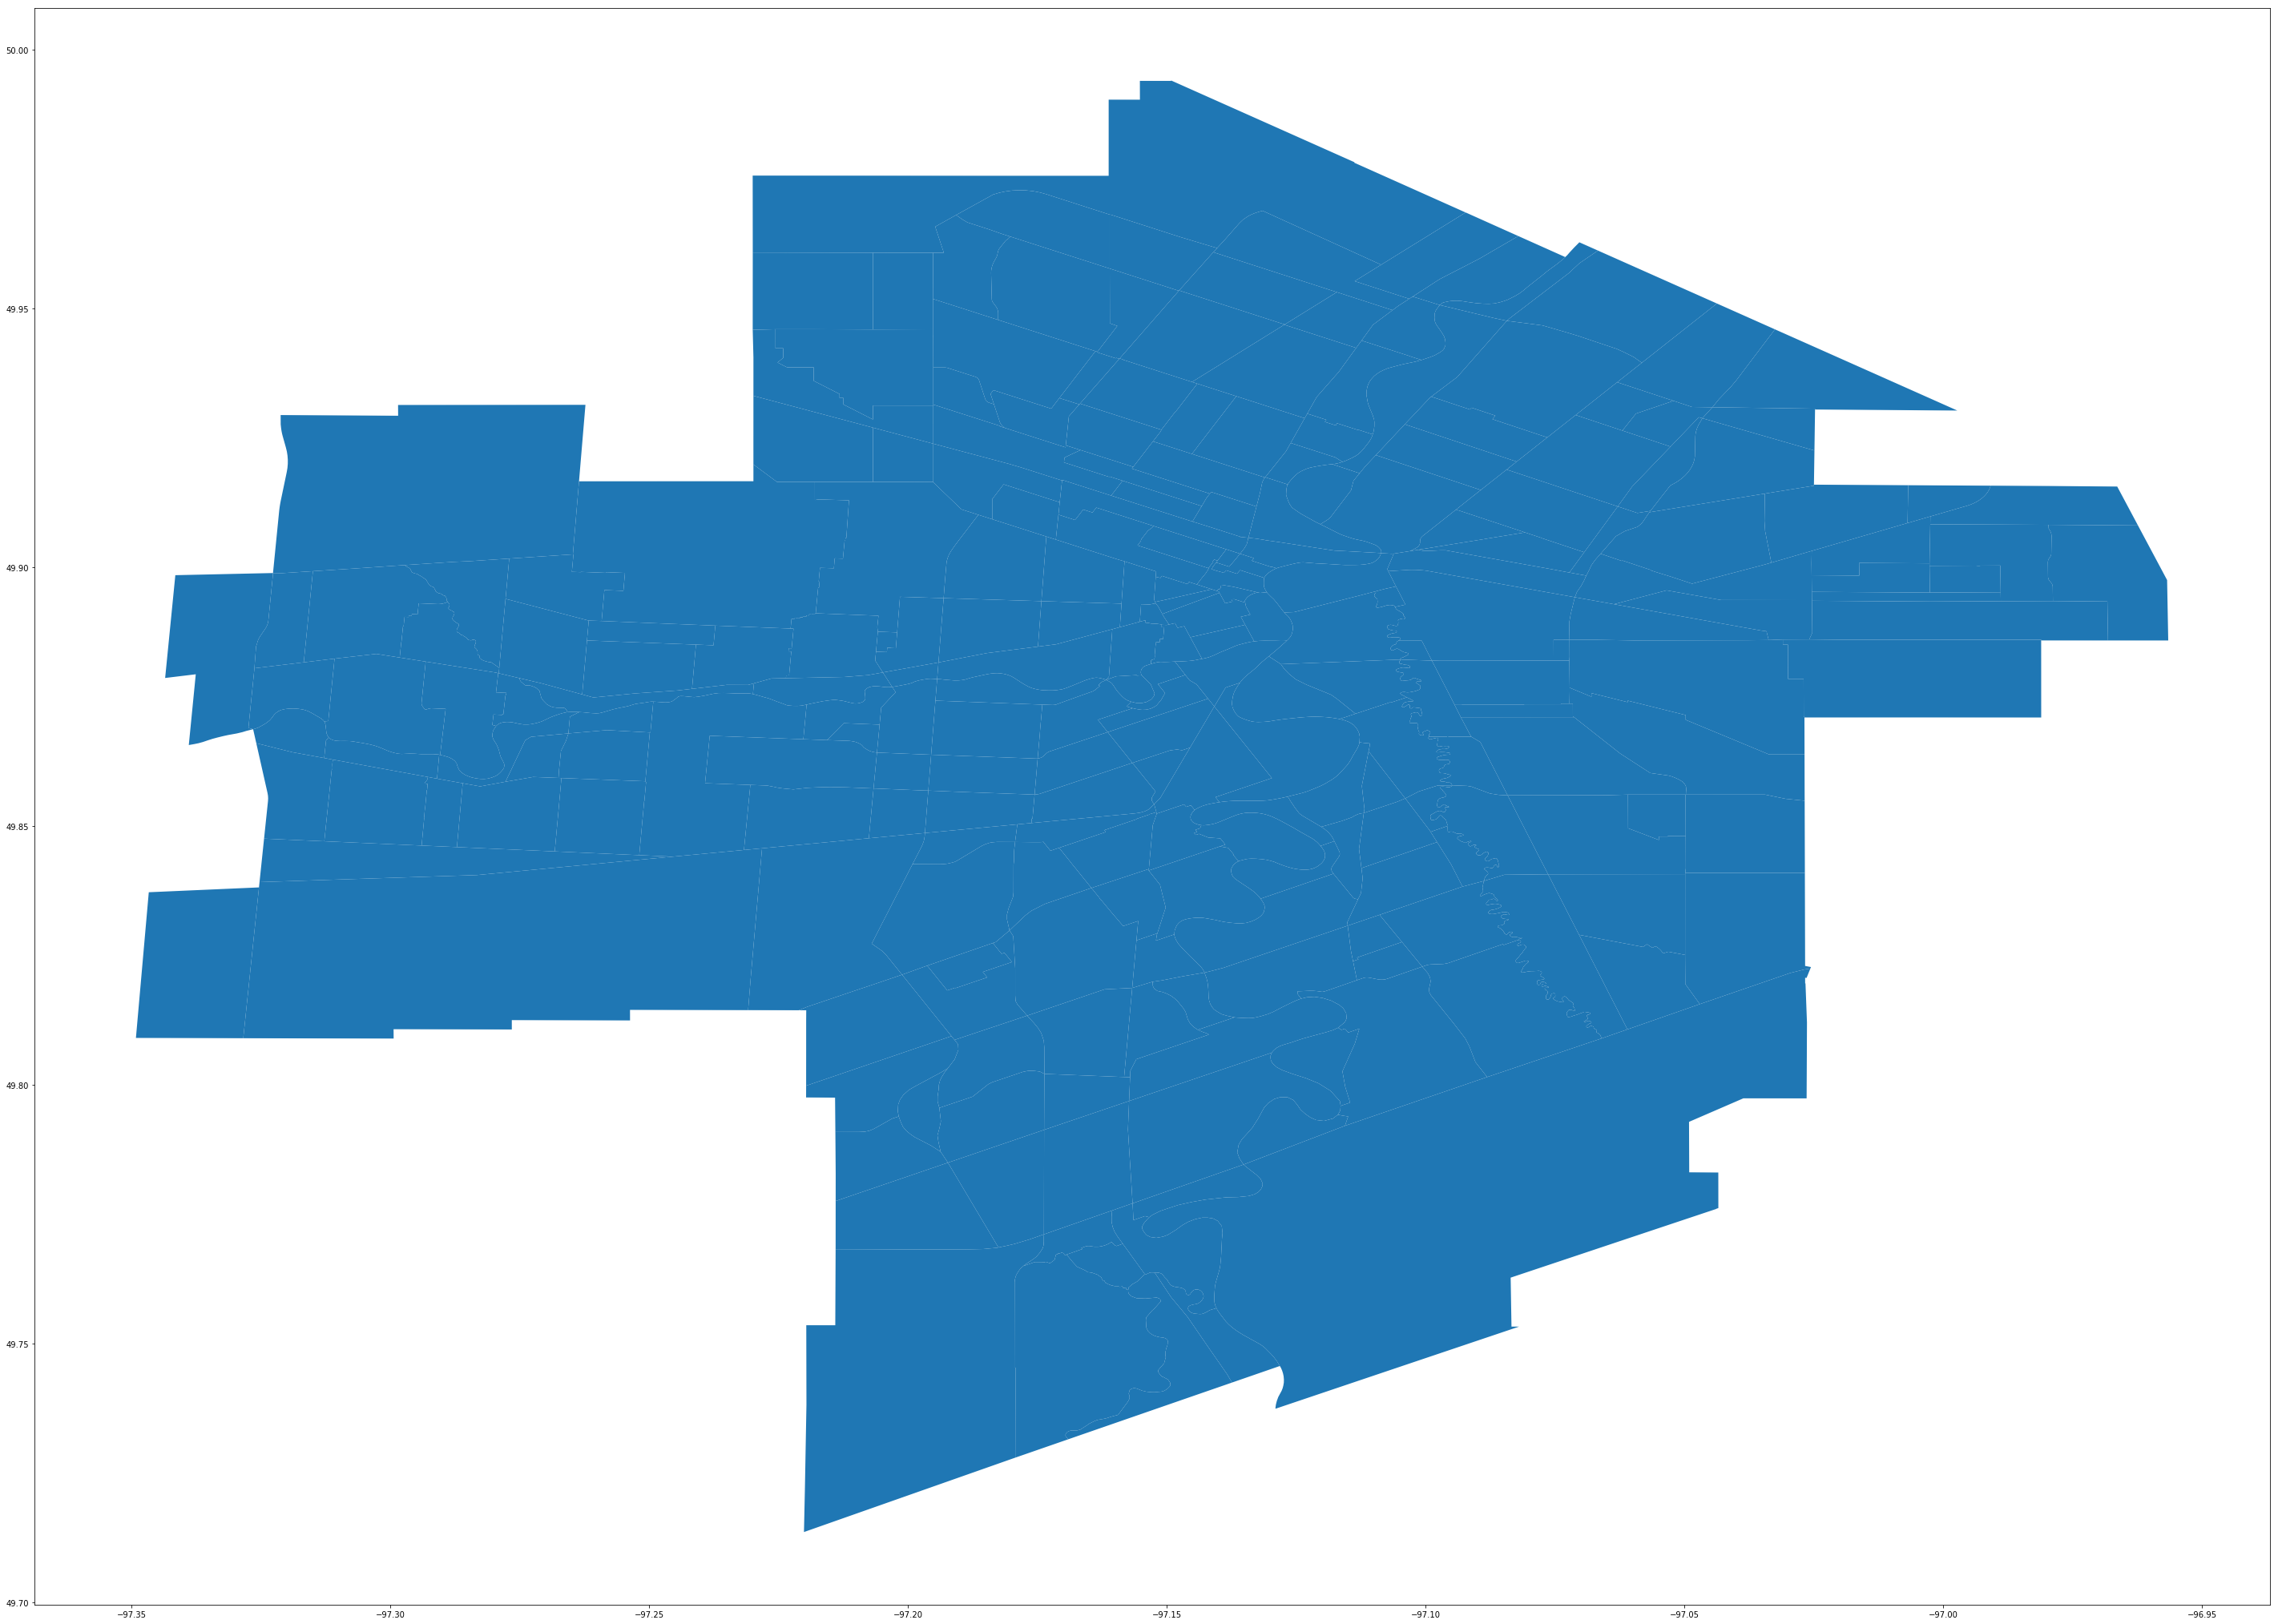

In [29]:
# checking if the map is being displayed correctly
fig,ax = plt.subplots(figsize = (50,50))
street_map.plot(ax = ax)

In [30]:
df_coord = df_no_19['Location 1'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'}) 
df_coord.head()

,Latitude,Longitude
0,49.8870652997693,-97.1440154766177
1,49.8913473998213,-97.0379600434883
2,49.8810695742732,-97.2097095425623
3,49.8642636908888,-97.1003745057038
4,49.8535993554956,-97.1289960439088


In [31]:
# Merging Lat and Long to the dataframe 
df2 = pd.concat([df_no_19, df_coord], axis=1)
df2.head()

,Dates,Hours,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Time,Latitude,Longitude
0,2017-05-10,14,Street Maintenance,Sidewalk Repairs,Fort Rouge - East Fort Garry,South Portage,"(49.8870652997693, -97.1440154766177)",Spring,Afternoon,49.8870652997693,-97.1440154766177
1,2017-08-25,8,By Law Enforcement,Neighbourhood Liveability Complaint,Transcona,Mission Gardens,"(49.8913473998213, -97.0379600434883)",Summer,Morning,49.8913473998213,-97.0379600434883
2,2017-04-10,11,Sewer & Drainage,Sewer Backup,St. James,King Edward,"(49.8810695742732, -97.2097095425623)",Spring,Morning,49.8810695742732,-97.2097095425623
3,2018-01-15,11,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8642636908888, -97.1003745057038)",Winter,Morning,49.8642636908888,-97.1003745057038
4,2018-11-22,10,Garbage & Recycling,Missed Recycling Collection,St. Vital,Kingston Crescent,"(49.8535993554956, -97.1289960439088)",Autumn,Morning,49.8535993554956,-97.1289960439088


In [32]:
df2[['Latitude', 'Longitude']] = df2[['Latitude', 'Longitude']].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122315 entries, 0 to 137612
Data columns (total 11 columns):
Dates              122315 non-null datetime64[ns]
Hours              122315 non-null int64
Service Area       122315 non-null object
Service Request    122315 non-null object
Ward               122315 non-null object
Neighbourhood      122315 non-null object
Location 1         122315 non-null object
Season             122315 non-null object
Time               122315 non-null object
Latitude           122315 non-null float64
Longitude          122315 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 11.9+ MB


#### 4.2 - Creating Points for Lat and Long.

In [33]:
# A Point is essentially a single object that describes the longitude and latitude of a data-point. 
geometry = [Point(xy) for xy in zip( df2['Longitude'], df2['Latitude'])]
geometry[:3]

In [34]:
crs = {'init': 'epsg:4326'}

In [35]:
df2 = gdp.GeoDataFrame(df2, crs=crs, geometry=geometry)
df2.head()

,Dates,Hours,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Time,Latitude,Longitude,geometry
0,2017-05-10,14,Street Maintenance,Sidewalk Repairs,Fort Rouge - East Fort Garry,South Portage,"(49.8870652997693, -97.1440154766177)",Spring,Afternoon,49.887065,-97.144015,POINT (-97.1440154766177 49.8870652997693)
1,2017-08-25,8,By Law Enforcement,Neighbourhood Liveability Complaint,Transcona,Mission Gardens,"(49.8913473998213, -97.0379600434883)",Summer,Morning,49.891347,-97.037960,POINT (-97.0379600434883 49.8913473998213)
2,2017-04-10,11,Sewer & Drainage,Sewer Backup,St. James,King Edward,"(49.8810695742732, -97.2097095425623)",Spring,Morning,49.881070,-97.209710,POINT (-97.20970954256229 49.8810695742732)
3,2018-01-15,11,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8642636908888, -97.1003745057038)",Winter,Morning,49.864264,-97.100375,POINT (-97.1003745057038 49.8642636908888)
4,2018-11-22,10,Garbage & Recycling,Missed Recycling Collection,St. Vital,Kingston Crescent,"(49.8535993554956, -97.1289960439088)",Autumn,Morning,49.853599,-97.128996,POINT (-97.1289960439088 49.8535993554956)


#### 4.3 - Display the top 5 Service Requests in a Winnipeg city map

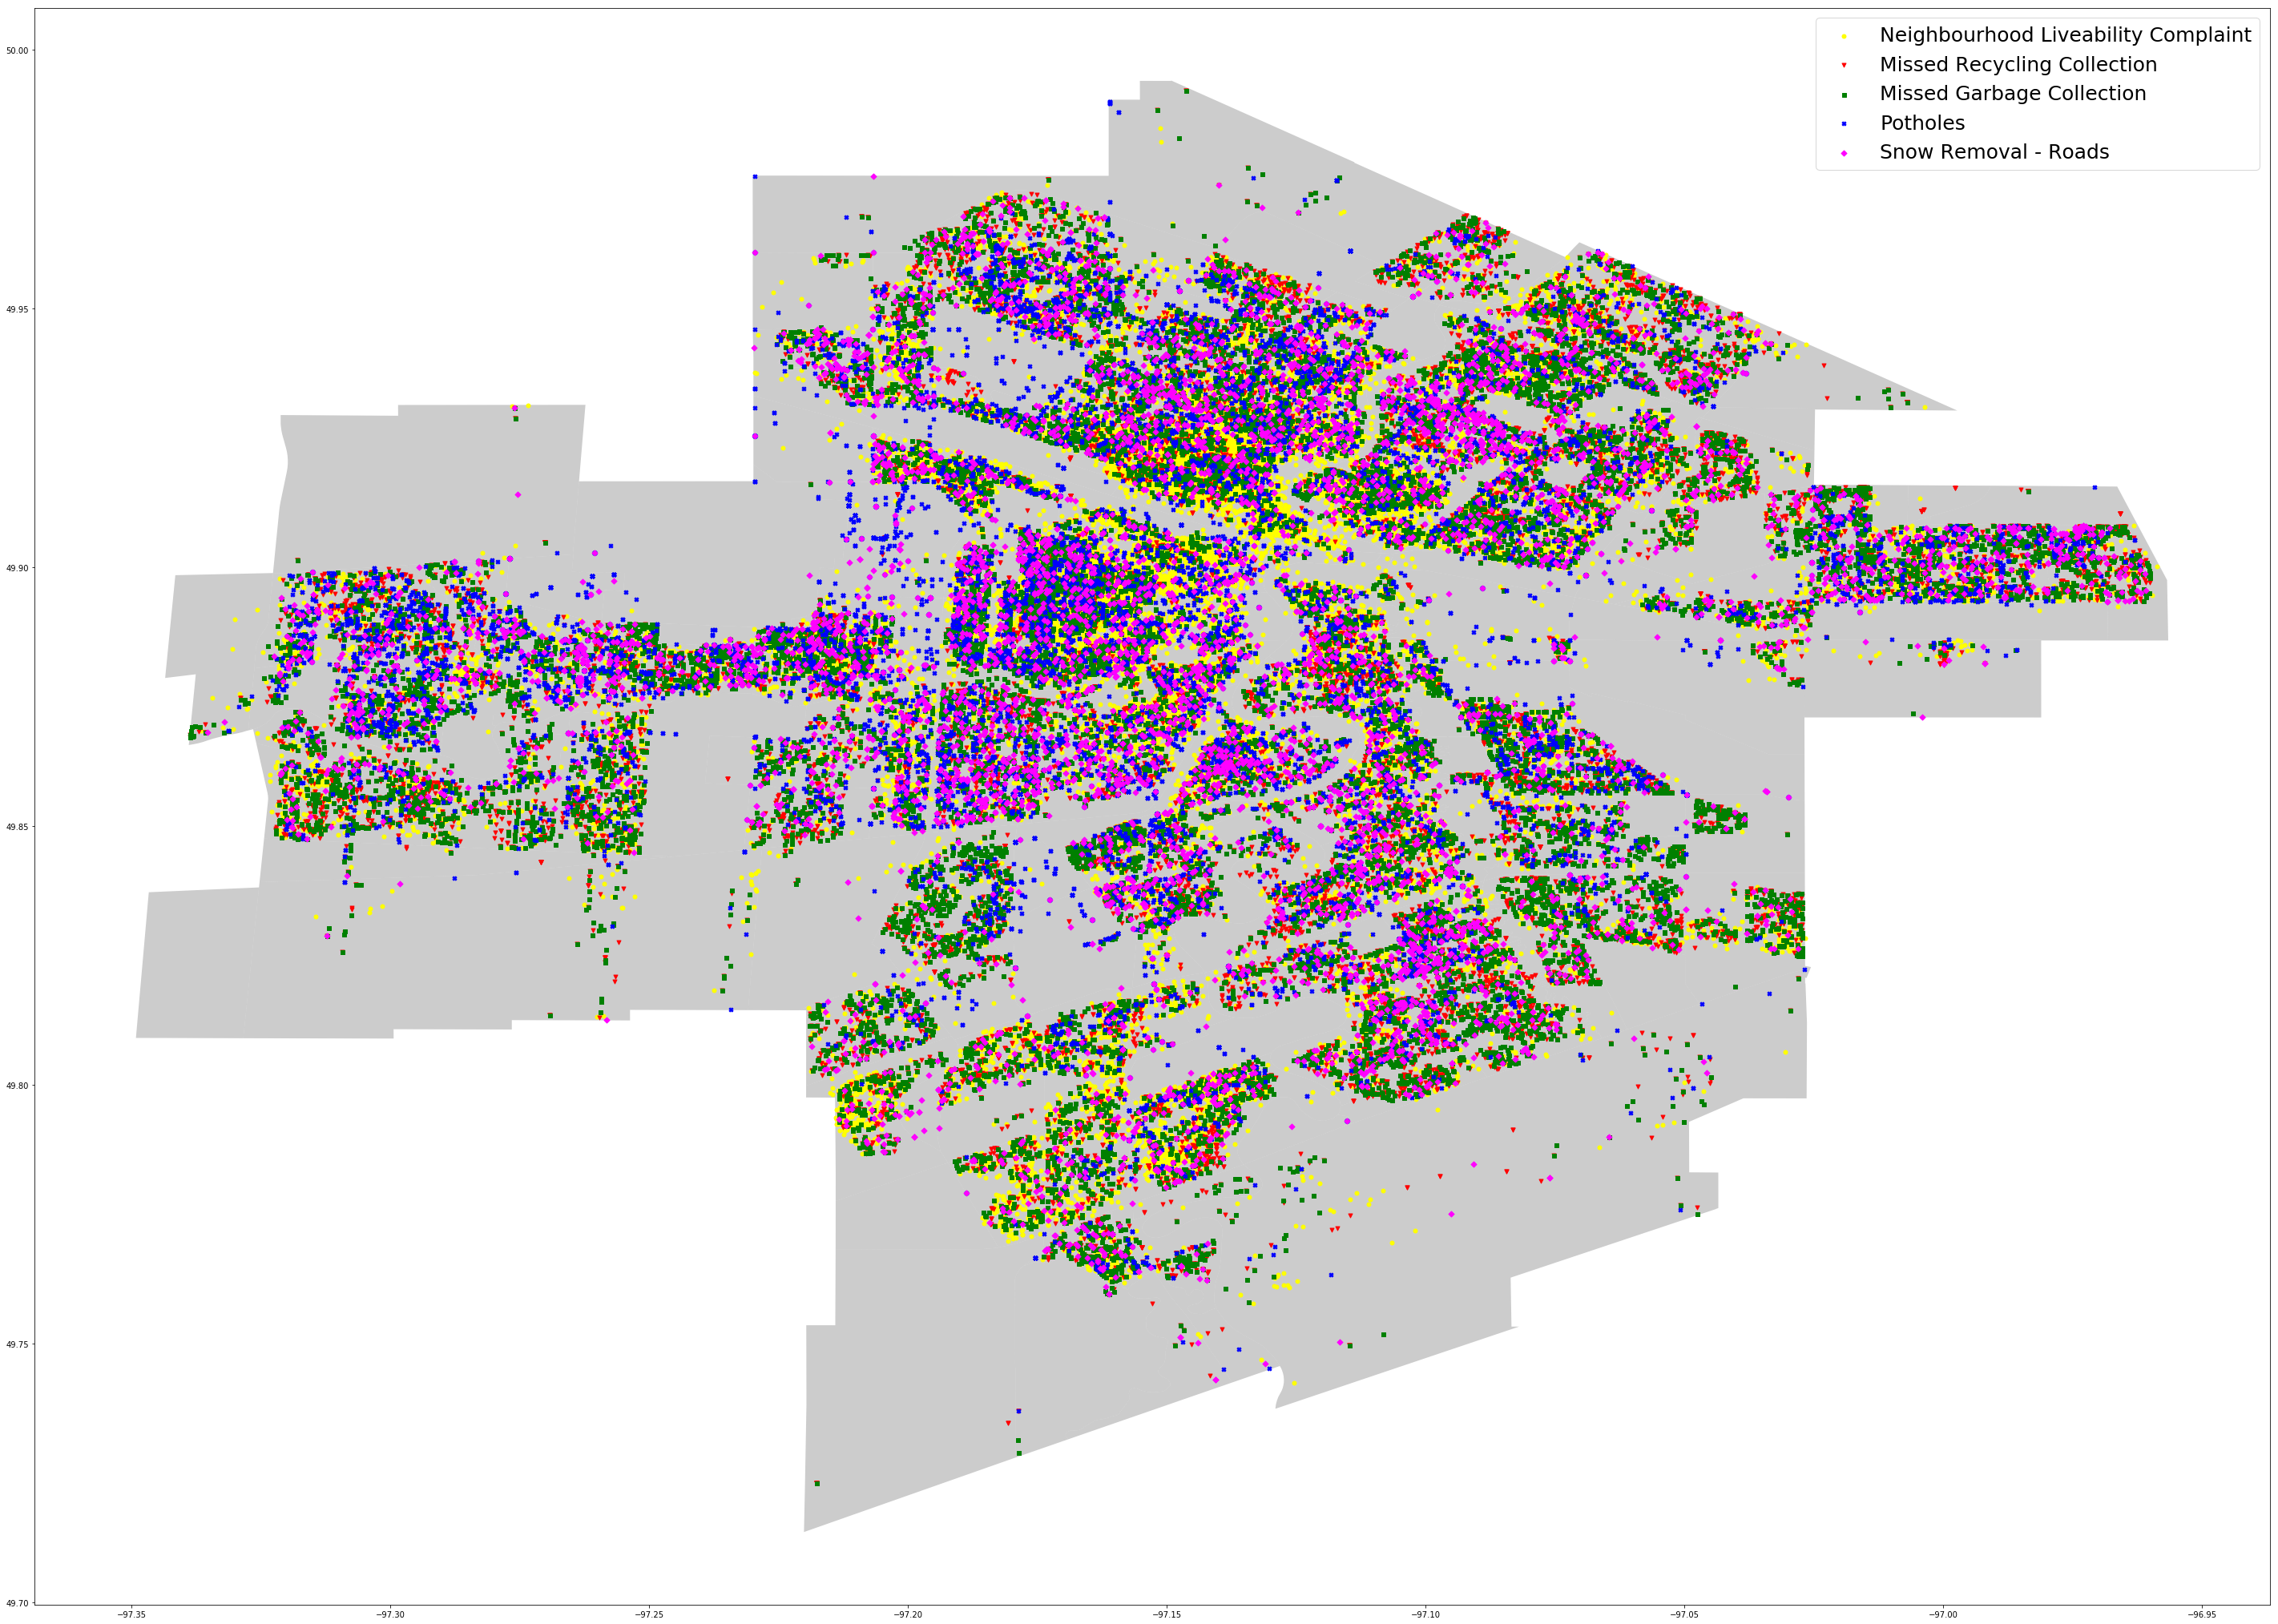

In [36]:
fig,ax = plt.subplots(figsize=(50,50))
street_map.plot(ax=ax, alpha=0.4, color="grey")
df2[df2['Service Request'] == 'Neighbourhood Liveability Complaint'].plot(ax = ax, markersize =25, color='yellow', marker='o', label='Neighbourhood Liveability Complaint')
df2[df2['Service Request'] == 'Missed Recycling Collection'].plot(ax = ax, markersize =25, color='red', marker='v', label='Missed Recycling Collection')
df2[df2['Service Request'] == 'Missed Garbage Collection'].plot(ax = ax, markersize =25, color='green', marker='s', label='Missed Garbage Collection')
df2[df2['Service Request'] == 'Potholes'].plot(ax = ax, markersize =25, color='blue',marker='X', label='Potholes')
df2[df2['Service Request'] == 'Snow Removal - Roads'].plot(ax = ax, markersize =25, color='fuchsia', marker='D', label='Snow Removal - Roads')
plt.legend(prop={'size':25})

- I can see a higher concentration of service requests in the center north region of the map.